# install prerequisite

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sat May  4 15:26:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-------

In [ ]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW


In [ ]:
def read_QA(path):
    with open(path, 'rb') as f:
        QA_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for item in QA_dict['data']:
      for paragraph in item['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    max_context_length = max(len(context) for context in contexts)
    max_answer_length = max(len(answer['text']) for answer in answers)
    max_question_length = max(len(question) for question in questions)


    #print("Maximum context length:", max_context_length)
    #print("Maximum question length:", max_question_length)
    #print("Maximum answer length:", max_answer_length)

    return contexts, questions, answers
print("Training set informaiton:")
train_contexts, train_questions, train_answers = read_QA('/content/train (1).json')
print(f"Length of each training array is {len(train_contexts)} elements")
print(f"The first 5 Questions of Training array:\n{train_questions[:5]}")
print('*'*10)
print("Validation set informaiton:")
val_contexts, val_questions, val_answers = read_QA('/content/test (1).json')
print(f"Length of each Validation array is {len(val_contexts)} elements")
print(f"The first 5 Questions of Validation array:\n{val_questions[:5]}")
print('*'*10)
print("Testing set informaiton:")
test_contexts, test_questions, test_answers = read_QA('/content/val (1).json')
print(f"Length of each testing array is {len(test_contexts)} elemants")
print(f"The first 5 Questions of Testing array:\n{test_questions[:5]}")

Training set informaiton:
Length of each training array is 847 elements
The first 5 Questions of Training array:
['ماذا يسبب تعرض النباتات لدرجات حرارة منحفضة؟', 'ماهي شجرة اللبخ؟', 'ماهي طريقة زراعة شجرة اللبخ؟', 'ماهي الأماكن المناسبة لزراعة شجرة اللبخ؟', 'ماهو المناخ المثالي لزراعة شجرة اللبخ؟']
**********
Validation set informaiton:
Length of each Validation array is 107 elements
The first 5 Questions of Validation array:
['ماهي نبتة الفيروكاكتوس ؟', 'ماهي طريقة زراعة نبتة الفيروكاكتوس ؟ ', 'ماهي طريقة العناية بنبتة الفيروكاكتوس ؟', 'ماهو المناخ المناسب لنبتة الفيروكاكتوس ؟', 'ماهي الأمراض التي تصيب نبتة الفيروكاكتوس؟']
**********
Testing set informaiton:
Length of each testing array is 108 elemants
The first 5 Questions of Testing array:
['ماهو نبات دراسينا؟', 'ماهي طريقة زراعة نبات دراسينا؟ ', 'ماهي طريقة العناية بنبات دراسينا؟', 'ماهو المناخ المناسب لنبات دراسينا؟', 'ماهي الأمراض التي تصيب نبات دراسينا؟']


# **Add start and end for every answer**

In [ ]:
print(f"A sample of train answers array before adding 'answer_end' : {train_answers[0]}")
def add_start_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = context.index(gold_text,0)
        end_idx = start_idx + len(gold_text)

        if context[start_idx:end_idx] == gold_text:
            answer['answer_start'] = start_idx
            answer['answer_end'] = end_idx


add_start_end_idx(train_answers, train_contexts)
add_start_end_idx(val_answers, val_contexts)
add_start_end_idx(test_answers, test_contexts)
print(f"A sample of train answers array after adding 'answer_end' :{train_answers[0]}")

A sample of train answers array before adding 'answer_end' : {'text': 'ظهور بقع سوداء أو بيضاء غير منتظمة.', 'answer_start': 324}
A sample of train answers array after adding 'answer_end' :{'text': 'ظهور بقع سوداء أو بيضاء غير منتظمة.', 'answer_start': 324, 'answer_end': 359}


# ***  Preprocessing step for context ***


In [ ]:
# from arabert.preprocess import ArabertPreprocessor

# model_name = 'aubmindlab/bert-base-arabertv02'
# arabert_prep = ArabertPreprocessor(model_name)

In [ ]:
# # Applying the arabert preprocessor to the 'train_context'
# preprocessed_tarined_contexts = []
# for context in train_contexts:
#     preprocessed_context = arabert_prep.preprocess(context)
#     preprocessed_tarined_contexts.append(preprocessed_context)


In [ ]:
# # Applying the arabert preprocessor to the 'val_context'
# preprocessed_val_contexts = []
# for context in val_contexts:
#     preprocessed_context = arabert_prep.preprocess(context)
#     preprocessed_val_contexts.append(preprocessed_context)

# **Making sure every answer has an end key**




In [ ]:
def find_dicts_without_answer_end(answers):
    dicts_without_answer_end = []
    for i, answer_dict in enumerate(answers):
        if 'answer_end' not in answer_dict:
            dicts_without_answer_end.append((i, answer_dict))
    return dicts_without_answer_end

In [ ]:
dicts_without_answer_end = find_dicts_without_answer_end(train_answers)
if dicts_without_answer_end:
    print("Dictionaries without 'answer_end' key:")
    for index, answer_dict in dicts_without_answer_end:
        print(f"Index: {index}, Dictionary: {answer_dict}")
else:
    print("All dictionaries in train_answers have 'answer_end' key.")

All dictionaries in train_answers have 'answer_end' key.


In [ ]:
dicts_without_answer_end = find_dicts_without_answer_end(val_answers)
if dicts_without_answer_end:
    print("Dictionaries without 'answer_end' key:")
    for index, answer_dict in dicts_without_answer_end:
        print(f"Index: {index}, Dictionary: {answer_dict}")
else:
    print("All dictionaries in val_answers have 'answer_end' key.")

All dictionaries in val_answers have 'answer_end' key.


In [ ]:
dicts_without_answer_end = find_dicts_without_answer_end(test_answers)
if dicts_without_answer_end:
    print("Dictionaries without 'answer_end' key:")
    for index, answer_dict in dicts_without_answer_end:
        print(f"Index: {index}, Dictionary: {answer_dict}")
else:
    print("All dictionaries in test_answers have 'answer_end' key.")

All dictionaries in test_answers have 'answer_end' key.


# **Tokenizer**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('MMars/Question_Answering_AraBERT_xtreme_ar')
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
test_encodings = tokenizer(test_contexts, test_questions, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(f"Encodings before: {train_encodings[1]}")

Encodings before: Encoding(num_tokens=463, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']-1))
        # if None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
add_token_positions(test_encodings, test_answers)
print(f"Encodings after: {train_encodings[1]}")

Encodings after: Encoding(num_tokens=463, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


# Dataset loader and model setting

---



In [ ]:
class QADataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = QADataset(train_encodings)
val_dataset = QADataset(val_encodings)
test_dataset = QADataset(test_encodings)
print(f"A sample of train answers after tokanization :\n {train_dataset[1]}")

A sample of train answers after tokanization :
 {'input_ids': tensor([    2, 13461, 34291,   200, 19673,  1585,   121, 12190, 28096,   103,
         1034,   306, 19304, 20950, 10564,  1281,   103, 58608,   181, 14227,
         2136, 28611,   103, 26667, 28611,   103, 35579,   305,  3631, 17197,
         1557,   305,  1282,   773,  1160,   103, 31801,   465,   233,   199,
        52117,   103, 17056, 54267, 10221,  1305, 47292,  3165,    20,  9733,
        47554, 26932, 31045,  1338,  2077,   420, 41768, 21136,   324,  9309,
          914, 57362,   315, 46055,   817, 10216,   201,  6912, 17243, 12368,
         1632,  6289,   383,  1377,   816, 56067,   198,  1693,   563,   829,
          819, 49675,   401,  1023,   802,    20,     3, 25830, 13461, 34291,
          200,   105,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
  

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained('MMars/Question_Answering_AraBERT_xtreme_ar')

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for layer_idx in range(1):
    for name, param in model.bert.encoder.layer[layer_idx].named_parameters():
        param.requires_grad = False
for name, param in model.bert.named_parameters():
    print(f"Parameter: {name}, requires_grad: {param.requires_grad}")

Parameter: embeddings.word_embeddings.weight, requires_grad: True
Parameter: embeddings.position_embeddings.weight, requires_grad: True
Parameter: embeddings.token_type_embeddings.weight, requires_grad: True
Parameter: embeddings.LayerNorm.weight, requires_grad: True
Parameter: embeddings.LayerNorm.bias, requires_grad: True
Parameter: encoder.layer.0.attention.self.query.weight, requires_grad: False
Parameter: encoder.layer.0.attention.self.query.bias, requires_grad: False
Parameter: encoder.layer.0.attention.self.key.weight, requires_grad: False
Parameter: encoder.layer.0.attention.self.key.bias, requires_grad: False
Parameter: encoder.layer.0.attention.self.value.weight, requires_grad: False
Parameter: encoder.layer.0.attention.self.value.bias, requires_grad: False
Parameter: encoder.layer.0.attention.output.dense.weight, requires_grad: False
Parameter: encoder.layer.0.attention.output.dense.bias, requires_grad: False
Parameter: encoder.layer.0.attention.output.LayerNorm.weight, requ

In [ ]:
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

optim = AdamW(model.parameters(), lr=0.0001,no_deprecation_warning=True)


# model training

Epoch 1/15,Train Loss: 2.7712741860976586, Val Loss: 1.963636647571217
Epoch 2/15,Train Loss: 1.524397027798188, Val Loss: 1.2272485995834523
Epoch 3/15,Train Loss: 0.8398300192008415, Val Loss: 0.973262579264966
Epoch 4/15,Train Loss: 0.4754907316886462, Val Loss: 1.0737006970765917
Epoch 5/15,Train Loss: 0.3255338975323889, Val Loss: 1.0597977137023753
Epoch 6/15,Train Loss: 0.28972838355753666, Val Loss: 1.2690761414441196

Early stopping triggered after 3 epochs without improvement.


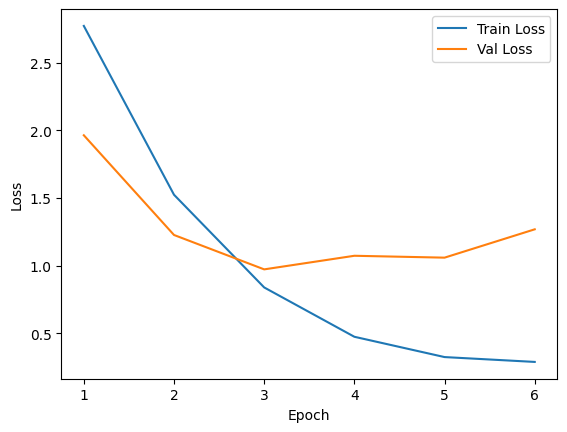

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
epochs = 15

# Early stopping variables
best_val_loss = float('inf')
epochs_since_improvement = 0
patience = 3

for epoch in range(epochs):
    # Training phase
    epoch_train_losses = []
    model.train()
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()
        epoch_train_losses.append(loss.item())

    epoch_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(epoch_train_loss)

    # Validation phase
    epoch_val_losses = []
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            epoch_val_losses.append(loss.item())

    epoch_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    print(f"Epoch {epoch + 1}/{epochs},Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}")
    val_losses.append(epoch_val_loss)


         # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_since_improvement = 0
        # Save the best model weights (optional)
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement >= patience:
        print(f"\nEarly stopping triggered after {epochs_since_improvement} epochs without improvement.")
        break


# Plot the training and validation losses

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# model testing



In [ ]:
!pip install nltk

In [ ]:
#run it to show the model preformence at the inflection point
# try:
#   model.load_state_dict(torch.load('best_model.pt'))
#   print("Loaded best saved model 'best_model.pt'")
# except FileNotFoundError:
#   print("Best model 'best_model.pt' not found. Continuing with training model.")


In [ ]:
from sklearn.metrics import f1_score
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

references = []  # List to store the reference sentences
hypotheses = []  # List to store the generated/hypothesized sentences
acc = []
all_start_pred = []
all_end_pred = []
all_start_true = []
all_end_true = []

model.eval()

for batch in tqdm(test_loader):
    with torch.no_grad():

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)

        # make predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        # pull preds out
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)

        # Append predictions and true values for each example
        all_start_pred.extend(start_pred.cpu().numpy())
        all_end_pred.extend(end_pred.cpu().numpy())
        all_start_true.extend(start_true.cpu().numpy())
        all_end_true.extend(end_true.cpu().numpy())

        # calculate accuracy for both and append to accuracy list
        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

        # Convert predictions to sentences
        for i in range(len(start_pred)):
            start_idx = start_pred[i].item()
            end_idx = end_pred[i].item()
            input_tokens = tokenizer.convert_ids_to_tokens(input_ids[i])
            predicted_tokens = input_tokens[start_idx: end_idx + 1]
            predicted_sentence = tokenizer.convert_tokens_to_string(predicted_tokens)
            hypotheses.append(predicted_sentence)

        # Convert true answers to sentences
        for i in range(len(start_true)):
            start_idx = start_true[i].item()
            end_idx = end_true[i].item()
            input_tokens = tokenizer.convert_ids_to_tokens(input_ids[i])
            true_tokens = input_tokens[start_idx: end_idx + 1]
            true_sentence = tokenizer.convert_tokens_to_string(true_tokens)
            references.append([true_sentence])

# Calculate F1 score
start_f1 = f1_score(all_start_true, all_start_pred, average='micro')
end_f1 = f1_score(all_end_true, all_end_pred, average='micro')
overall_f1 = (start_f1 + end_f1) / 2


# calculate average accuracy in total
accuracy = sum(acc) / len(acc)

# Calculate Exact Match (EM) score
num_exact_matches = 0
total_examples = len(all_start_pred)
for i in range(total_examples):
    start_pred = all_start_pred[i]
    end_pred = all_end_pred[i]
    start_true = all_start_true[i]
    end_true = all_end_true[i]
    if start_pred == start_true and end_pred == end_true:
        num_exact_matches += 1
em = num_exact_matches / total_examples

# Calculate BLEU score
bleu_score = corpus_bleu(references, hypotheses)

print(f'\nF1 = {overall_f1}')
print(f'EM = {em}')
print(f'ACC = {accuracy}')
print(f'BLEU = {bleu_score}')


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


F1 = 0.7867647058823529
EM = 0.6617647058823529
ACC = 0.7847222222222222
BLEU = 0.8225175664839919


In [ ]:
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

# Model saving

In [ ]:
model_save_path = "/content/model"
model.save_pretrained(model_save_path)

In [ ]:
tokenizer.save_pretrained(model_save_path)

('/content/model/tokenizer_config.json',
 '/content/model/special_tokens_map.json',
 '/content/model/vocab.txt',
 '/content/model/added_tokens.json',
 '/content/model/tokenizer.json')

# pipeline

In [ ]:
from transformers import pipeline
model = AutoModelForQuestionAnswering.from_pretrained(model_save_path)
pipe = pipeline(model = model,
        tokenizer= tokenizer,
        task="question-answering"
        )

In [ ]:
context = "الأثاب هي أشجار خضراء كبيرة جميلة، وارفة الظلال. تصلح لتزيين الحدائق والمتنزهات والأرصفة."
question = "ماهي استعمالات شجرة الأثاب؟"

# Perform inference using the pipeline
result = pipe(context=context, question=question)

# Extract the answer
answer = result["answer"]

print("Question:", question)
print("Answer:", answer)


Question: ماهي استعمالات شجرة الأثاب؟
Answer: لتزيين الحدائق والمتنزهات والأرصفة


In [ ]:
question = "كم يصل حجم قطر أزهار البوق الذهبي؟"
context ="شجيرات الألمندا الصفراء من نباتات الزينة الملتفة المتسلقة، وموطنها الأصلي شمال البرازيل. ويمكن أن تشكل تغطية تامة للجدران التي تستند إليها بصورة جذابة. وأزهارها الجذابة صفراء اللون يصل حجمها إلى 12 سنتمتر في القطر.وعند توفر الظروف فإنها تعطي منظرًا وجمالًا مميزًا وتنمو في نورات غير محدودة في أشهر الصيف يتبعها ثمار ذات أشواك لها بذور مجنحة. والأماكن المشمسة جيدة التصريف مهمة لهذه النباتات، في حالة شح المياه فإنها تستمر في النمو، وهي تنمو سريعًا في الترب الرطبة عالية المستوى الرطوبي قليلة الملوحة، كما تتحمل الفترات الباردة ولكن الصقيع يؤثر على الأوراق بسرعة"
result = pipe(context=context, question=question)

answer = result["answer"]
print("Question:", question)
print("Answer:", answer)

Question: كم يصل حجم قطر أزهار البوق الذهبي؟
Answer: 12 سنتمتر في القطر


In [ ]:
question = "ماهو المناخ المثالي لزراعة ذيل القط الأحمر؟"
context ="ويمكن زراعتها بالبذور أو بالأفرع، وتظهر بصورة جميلة في النباتات المؤنثة التي تعطي الأزهار الجميلة، ويمكن أن تتأقلم مع البيئات المشابهة لموطنها الأصلي من حيث الرطوبة العالية إلا أنها غير مناسبة لأجواء الرياض الجافة؛ لذا تحتاج إلى اختيار مواقع مناسبة ظليلة وعالية الرطوبة، ويمكن أن تُتخذ نبات زينة داخليا."
result = pipe(context=context, question=question)

answer = result["answer"]
print("Question:", question)
print("Answer:", answer)

Question: ماهو المناخ المثالي لزراعة ذيل القط الأحمر؟
Answer: تحتاج إلى اختيار مواقع مناسبة ظليلة وعالية الرطوبة
